# Data science project   
## Tweet snetiment analysis    

In the framework of the data science course, we have to carry out a first deep learning project. The objective of this project is to conduct a study to determine the global sentiment of a tweet from a dataset of tweets on the COVID. 

### Import

In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import keras as kr
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maxence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data import

In [3]:
data_train = pd.read_csv('Corona_NLP_train.csv',encoding='latin')
data_test = pd.read_csv('Corona_NLP_test.csv',encoding ='latin')

### Analysis of the dataset 

In [4]:
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


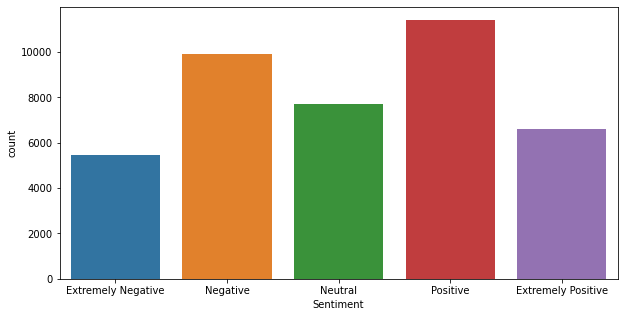

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=data_train, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], )
plt.show()

In [6]:
data_train['Location'].value_counts()[0:10]

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [7]:
data_train.shape, data_test.shape

((41157, 6), (3798, 6))

We notice that we have 41257 tweets in our training dataset. They are composed of 6 variables. The user name, screen name, the location of the tweet, the date, the whole tweet and finally the sentiment of this tweet.  
The goal of the project is to find a reliable model to predict the sentiment of an input tweet.  

We will only use the "OriginalTweet" feature in our project. The prediction will therefore be based only on the tweets and not on the meta-data that accompanies them. We will therefore perform an NLP type network. Natural language processing 

### Data Preprocessing

In [48]:
name_features = ['OriginalTweet'] # features selection 
name_label = ['Sentiment'] # labels selection 
#copy of the data into matrix X and vector Y 
X_train = data_train[name_features].copy()
Y_train = data_train[name_label].copy()
X_test = data_test[name_features].copy()
Y_test = data_test[name_label].copy()


In [49]:
sentiment = np.unique(data_train['Sentiment'])

For simplicity we will reduce the possible sentiments to [Positive, Negative, Neutral] and encode them as [0,1,2]. This reduction is relevant because we want to capture the overall sentiment of a tweet. An "Extremely Negative" tweet is above all "negative". We therefore reduce the values that the labels can take and therefore increase the tweets available for learning in each of the label categories.



In [50]:
code = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

Y_train.replace(code,inplace=True)
Y_test.replace(code,inplace=True)

### Data Cleaning

We now need to clean up the tweets so that they can be given to a learning system. To do this we will remove all special characters, https links, and use a library that contains stopwords which are words that do not provide information, e.g. 'the', 'a', 'it', etc. We can then remove them from the tweets. 

In [11]:
stopword = stopwords.words('english')
print('Stopwords List  :\n' ,stopword)

Stopwords List  :
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

In [12]:
#Input = tweets 
def clean(X) : 
    X = re.sub(r'@\w+',' ',X)
    X = re.sub(r'http\S+',' ',X)
    X = re.sub(r'#\w+', ' ', X )
    X = re.sub(r'\d+',' ', X)
    X = re.sub(r'#\w+',' ',X)
    X = re.sub(r'<.*?>\w+',' ',X)
    X = X.lower()

    X = re.sub(r'[^a-z0-1\s]','',X) 
    X = X.split()

    stopword=stopwords.words('english')
    X= " ".join([mot for mot in X if not mot in stopword])
    return X

In [13]:
X_train_clean = X_train['OriginalTweet'].apply(clean).copy()
X_test_clean = X_test['OriginalTweet'].apply(clean).copy()

In [14]:
X_train_clean

0                                                         
1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please dont panic enough ...
4        ready go supermarket outbreak im paranoid food...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    know getting tough rationing toilet paper mart...
41155             wrong smell hand sanitizer starting turn
41156    well newused rift going amazon rn although nor...
Name: OriginalTweet, Length: 41157, dtype: object


We now have "clean" tweets, i.e. with only "important" words, no more "@" mentions, no more "#". There is also no punctuation. 

### WordCloud

In [15]:
join_tweet_negative=""
join_tweet_neutre = ""
join_tweet_positif = ""

for i in range (len(X_train_clean)):
    if Y_train["Sentiment"][i]== 0 : 
        join_tweet_negative += "".join(X_train_clean[i])+" "
    elif Y_train["Sentiment"][i]==1 :
        join_tweet_neutre += "".join(X_train_clean[i])+ " "
    else : 
        join_tweet_positif += "".join(X_train_clean[i])+" "
        
    
def print_wordcloud(text,color):
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap=color,
                min_font_size = 10).generate(text) 
    return wordcloud
    

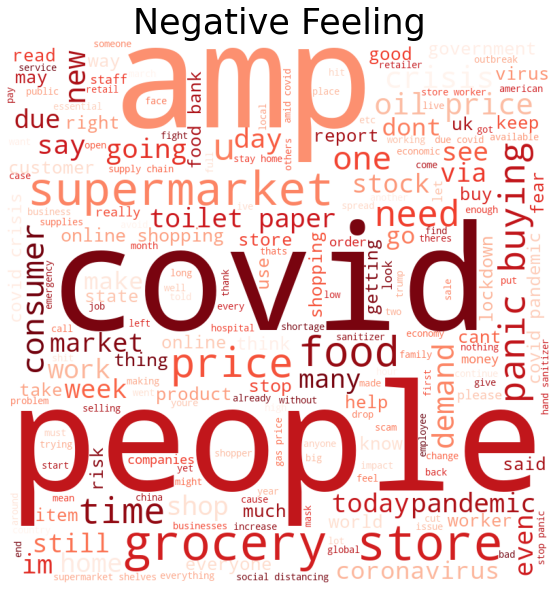

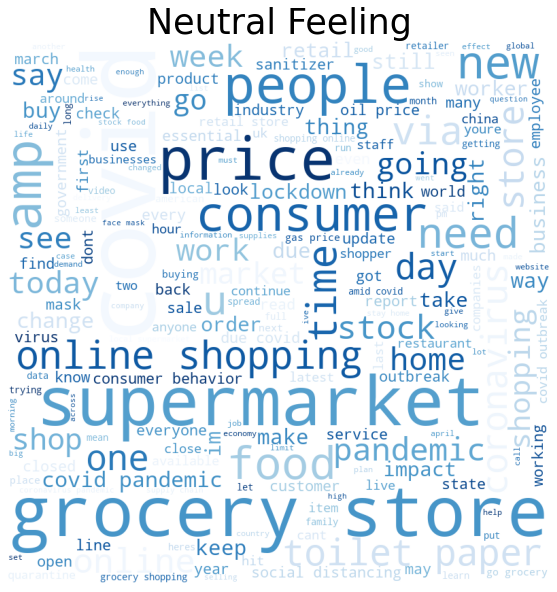

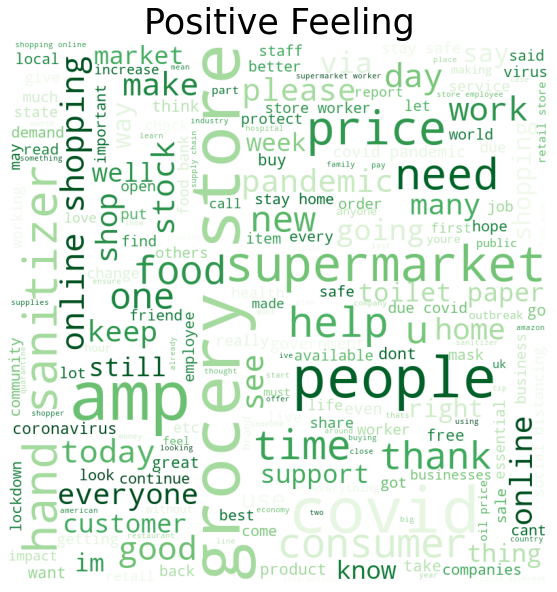

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_negative,"Reds"))
plt.axis('off')
plt.title('Negative Feeling',fontsize=35)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_neutre,"Blues"))
plt.axis('off')
plt.title('Neutral Feeling',fontsize=35)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(print_wordcloud(join_tweet_positif,"Greens"))
plt.axis('off')
plt.title('Positive Feeling',fontsize=35)
plt.show()

### Tokenizing

In [46]:
size = np.zeros_like(X_train_clean)
for i in range(len(X_train_clean)):
    size[i] = len(X_train_clean[i])
size_max = np.max(size) 
size_max

266

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_clean)

taille_vocabulaire = len(tokenizer.word_index) + 1


X_train_clean = tokenizer.texts_to_sequences(X_train_clean)
X_test_clean = tokenizer.texts_to_sequences(X_test_clean)

In [47]:
X_train_clean = pad_sequences(X_train_clean, maxlen=size_max, padding='post')
X_test_clean = pad_sequences(X_test_clean, maxlen=size_max, padding='post')
X_train_clean

array([[    0,     0,     0, ...,     0,     0,     0],
       [  380,   732,  2334, ...,     0,     0,     0],
       [   24,   814,  4342, ...,     0,     0,     0],
       ...,
       [   54,   126,  1407, ...,     0,     0,     0],
       [  573,  3746,    26, ...,     0,     0,     0],
       [  100, 36599, 36600, ...,     0,     0,     0]], dtype=int32)

We transformed our tweets into a sequence of numbers which we then grouped into a matrix with the maximum size of the longest tweet of the train dataset, i.e. 266. 

### Model creation

In [27]:
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
tf.keras.backend.clear_session()

# hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    Layers.Embedding(taille_vocabulaire, embedding_dim, input_length=X_train_clean.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    Layers.Dropout(0.4),
    Layers.Dense(64, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
])

In [28]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 266, 16)           585632    
_________________________________________________________________
bidirectional (Bidirectional (None, 266, 512)          559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

Explanation of the network:  
1) First of all we used a Word Embeddings (Layers.Embedding) that is a representation of words in a n dim space learned with one of the neurons. Then each word is represented by a vector. Two words are close if their vectors are close.   


2) Next we have a layer of 256 bidirectional LSTM neurons. LSTMs are evolved RNNs for learning dependencies with a long memory. An LSTM contains 2 inputs: the old cell state and the vector. 3 types of gates: forget, input and finally the output gate. It uses the sigmoid activation function. And finally 2 outputs. Many calculations are performed in this type of cell.   
A BLSTM consists in executing at the same time 2 LSTM cells, one from left to right and the other in reverse. This calculates 2 vectors h which are then put together to give an output.  
This allows a better understanding of the semiotics of each teewt.


3) MaxPooling transforms each vector into a scalar of maximum size. 

We then have simple Dense neurons (forward propagations) with dropout layers that deactivate part of the neurons at each epoch to avoid overlearning 



We use only 2 epochs with a batch size of 32. 
We train on more than 1 million parameters 
Caution: The training is quite long 


In [29]:
##Training 
h  = model.fit(X_train_clean, Y_train, epochs=EPOCHS, validation_split=0.20, batch_size=BATCH_SIZE)

Epoch 1/2
1029/1029 [==============================] - 323s 312ms/step - loss: 0.8632 - accuracy: 0.5698 - val_loss: 0.4238 - val_accuracy: 0.8496
Epoch 2/2
1029/1029 [==============================] - 312s 303ms/step - loss: 0.3607 - accuracy: 0.8826 - val_loss: 0.3936 - val_accuracy: 0.8633


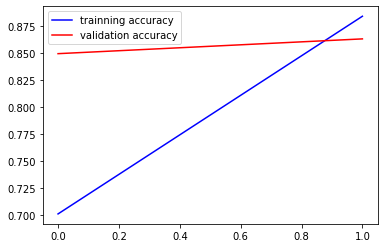

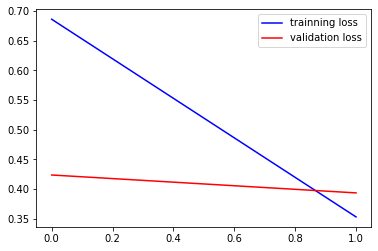

In [33]:
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

### Test of the model 

In [34]:
prediction = model.predict_classes(X_test_clean)

/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [35]:
print("Evaluate on test data")
results = model.evaluate(X_test_clean, Y_test)
print("test loss, test acc:", results)

Evaluate on test data
119/119 [==============================] - 11s 93ms/step - loss: 0.4561 - accuracy: 0.8449
test loss, test acc: [0.45606306195259094, 0.8449183702468872]


The result on the test set is 84% of accuracy

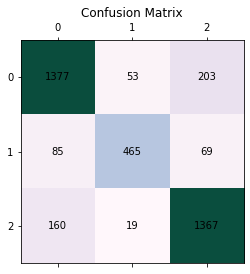

In [41]:
from sklearn.metrics import confusion_matrix
mat_conf = confusion_matrix(Y_test,prediction)


plt.matshow(mat_conf, cmap=plt.cm.PuBuGn, alpha=10)
for i in range(mat_conf.shape[0]):
    for j in range(mat_conf.shape[1]):
        plt.text(x=j, y=i, s=mat_conf[i, j], va='center', ha='center') 
plt.title('Confusion Matrix')
plt.show()


We notice that for example the model predicts 1366 negative times and the result is really negative. On the other hand knowing the class 0, it predicted 215 times the class 2 (Positive)  

So we have a visual result of the good functioning of the network 

### Possible improvement 
 
We could have used other types of networks such as a two-way GAN to compare the results. 

## Conclusion 

This project has been very rewarding. We have started to understand how deep learning works on text. We discovered many things like tokenization, text preprocessing, stopwords and so on.   

This project is a very good way to start working with deep learning libraries 
